<a href="https://colab.research.google.com/github/AmedeeRoy/BirdDL/blob/main/Dive_Prediction_1D_5s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Seabird Diving Behaviour with GPS data

Supervized Learning with Deep Networks


## Connecting Drive and Github

In [1]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [3]:
%cd drive/My\ Drive/BirdDL

/content/drive/My Drive/BirdDL


## Data Formatting

In [4]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython
import datetime
import random
import pickle

import trip

In [5]:
# connect to database
conn = sqlite3.connect('/content/drive/My Drive/data/seabirdbank.db')

In [6]:
request = "SELECT DISTINCT lon, lat FROM fieldwork WHERE place='Pescadores'"
colony = pd.read_sql_query(request, conn)
colony = colony.values
colony

array([[-77.264, -11.773]])

In [7]:
request = "SELECT \
            trip.id as trip, gps.datetime, gps.lon, gps.lat\
            FROM gps \
            INNER JOIN trip ON gps.trip = trip.id \
            INNER JOIN bird ON trip.bird = bird.id \
            WHERE trip.file_gps IS NOT NULL \
            AND trip.file_tdr IS NOT NULL \
            AND (bird.fieldwork = 'P1108' OR bird.fieldwork = 'P1111' \
                OR bird.fieldwork = 'P1112' OR bird.fieldwork = 'P1113') \
            AND bird.species = 'SV'"

# substr(bird.fieldwork,1,1) = 'P'

gps = pd.read_sql_query(request, conn)
gps

,trip,datetime,lon,lat
0,P1108_4_SV_T1,2008-11-25 13:00:35,-77.264128,-11.773317
1,P1108_4_SV_T1,2008-11-25 13:00:36,-77.264118,-11.773235
2,P1108_4_SV_T1,2008-11-25 13:00:37,-77.264098,-11.773152
3,P1108_4_SV_T1,2008-11-25 13:00:38,-77.264113,-11.773060
4,P1108_4_SV_T1,2008-11-25 13:00:39,-77.264142,-11.772955
...,...,...,...,...
839803,P1113_50_SV_T2,2013-11-25 05:23:26,-77.264832,-11.773701
839804,P1113_50_SV_T2,2013-11-25 05:23:27,-77.264862,-11.773664
839805,P1113_50_SV_T2,2013-11-25 05:23:28,-77.264900,-11.773705
839806,P1113_50_SV_T2,2013-11-25 05:23:29,-77.264931,-11.773739


In [8]:
# check duplicated datetime in GPS trip
idx = gps.index[gps.loc[:, 'trip':'datetime'].duplicated(keep=False)]
idx_drop = [idx[i] for i in range(0, len(idx), 2)]
gps = gps.drop(idx_drop)

In [9]:
gps[gps.loc[:, 'trip':'datetime'].duplicated(keep=False)]

,trip,datetime,lon,lat


In [10]:
request = "SELECT \
            trip.id as trip, tdr.datetime, tdr.pressure \
            FROM tdr \
            INNER JOIN trip ON tdr.trip = trip.id \
            INNER JOIN bird ON trip.bird = bird.id \
            WHERE trip.file_gps IS NOT NULL \
            AND trip.file_tdr IS NOT NULL \
            AND (bird.fieldwork = 'P1108' OR bird.fieldwork = 'P1111' \
                OR bird.fieldwork = 'P1112' OR bird.fieldwork = 'P1113') \
            AND bird.species = 'SV'"

# WHERE substr(bird.fieldwork,1,1) = 'P' 

tdr = pd.read_sql_query(request, conn)
tdr

,trip,datetime,pressure
0,P1108_4_SV_T1,2008-11-25 13:00:35,-0.35
1,P1108_4_SV_T1,2008-11-25 13:00:36,-0.38
2,P1108_4_SV_T1,2008-11-25 13:00:37,-0.35
3,P1108_4_SV_T1,2008-11-25 13:00:38,-0.29
4,P1108_4_SV_T1,2008-11-25 13:00:39,-0.29
...,...,...,...
1086337,P1113_50_SV_T2,2013-11-25 05:23:26,-0.94
1086338,P1113_50_SV_T2,2013-11-25 05:23:27,-0.94
1086339,P1113_50_SV_T2,2013-11-25 05:23:28,-0.94
1086340,P1113_50_SV_T2,2013-11-25 05:23:29,-0.94


In [11]:
tdr['datetime'] = pd.to_datetime(tdr['datetime'], format='%Y-%m-%d %H:%M:%S')
gps['datetime'] = pd.to_datetime(gps['datetime'], format='%Y-%m-%d %H:%M:%S')

In [12]:
df = pd.merge(tdr, gps, on=['trip', 'datetime'], how='left')
df

,trip,datetime,pressure,lon,lat
0,P1108_4_SV_T1,2008-11-25 13:00:35,-0.35,-77.264128,-11.773317
1,P1108_4_SV_T1,2008-11-25 13:00:36,-0.38,-77.264118,-11.773235
2,P1108_4_SV_T1,2008-11-25 13:00:37,-0.35,-77.264098,-11.773152
3,P1108_4_SV_T1,2008-11-25 13:00:38,-0.29,-77.264113,-11.773060
4,P1108_4_SV_T1,2008-11-25 13:00:39,-0.29,-77.264142,-11.772955
...,...,...,...,...,...
1086337,P1113_50_SV_T2,2013-11-25 05:23:26,-0.94,-77.264832,-11.773701
1086338,P1113_50_SV_T2,2013-11-25 05:23:27,-0.94,-77.264862,-11.773664
1086339,P1113_50_SV_T2,2013-11-25 05:23:28,-0.94,-77.264900,-11.773705
1086340,P1113_50_SV_T2,2013-11-25 05:23:29,-0.94,-77.264931,-11.773739


In [13]:
# check NaN and fill with interpolations
[i for i, x in enumerate(df['lon'].isna()) if x]


df['lon'] = df['lon'].interpolate(method='polynomial', order=2)
df['lat'] = df['lat'].interpolate(method='polynomial', order=2)

In [14]:
len(df.trip.unique())

185

In [15]:
# threshold = 1
# path_folder = "./trajectory/"

# for t in df.trip.unique():
    
#     path_file = path_folder + t
#     df_trip = df[df.trip == t]
    
#     bias = np.median(df_trip.pressure.values)
  
#     plt.figure(figsize=(9, 3))

#     plt.subplot(1, 2, 1)
#     plt.plot(df_trip.datetime.values, df_trip.pressure.values)
#     plt.plot(df_trip.datetime.values, [threshold+bias for i in range(len(df_trip))], color = 'orange')

#     plt.subplot(1, 2, 2)
#     plt.plot(df_trip.lon.values, df_trip.lat.values)
#     plt.scatter(df_trip.lon.values[df_trip.pressure-bias > threshold], \
#                 df_trip.lat.values[df_trip.pressure-bias > threshold], c = 'orange')
    
#     plt.savefig(path_file)
#     plt.close()

In [16]:
bad_trip = ['P1111_9_SV_T1', 'P1111_13_SV_T6', 'P1111_41_SV_T2', 'P1111_46_SV_T5', 'P1111_52_SV_T1',
            'P1112_4_SV_T2', 'P1112_26_SV_T5', 'P1112_36_SV_T1', 'P1112_36_SV_T2', 'P1113_41_SV_T3',
           'P1113_50_SV_T2']

no_loop = ['P1112_26_SV_T1', 'P1112_26_SV_T2', 'P1112_26_SV_T3', 'P1112_26_SV_T4']

In [17]:
### remove bad data
idx = df.index[[(t in bad_trip or t in no_loop) for t in df.trip]]
df = df.drop(idx)

In [18]:
len(df.trip.unique())

170

## Trip Statistics

In [19]:
df_trip = df[df.trip == 'P1108_4_SV_T1']
df_trip

,trip,datetime,pressure,lon,lat
0,P1108_4_SV_T1,2008-11-25 13:00:35,-0.35,-77.264128,-11.773317
1,P1108_4_SV_T1,2008-11-25 13:00:36,-0.38,-77.264118,-11.773235
2,P1108_4_SV_T1,2008-11-25 13:00:37,-0.35,-77.264098,-11.773152
3,P1108_4_SV_T1,2008-11-25 13:00:38,-0.29,-77.264113,-11.773060
4,P1108_4_SV_T1,2008-11-25 13:00:39,-0.29,-77.264142,-11.772955
...,...,...,...,...,...
6622,P1108_4_SV_T1,2008-11-25 14:50:57,-0.29,-77.264097,-11.773710
6623,P1108_4_SV_T1,2008-11-25 14:50:58,-0.29,-77.264223,-11.773817
6624,P1108_4_SV_T1,2008-11-25 14:50:59,-0.26,-77.264307,-11.773860
6625,P1108_4_SV_T1,2008-11-25 14:51:00,-0.22,-77.264363,-11.773875


In [20]:
# create trip
t = trip.Trip(df_trip)
threshold = 1

# add variable
t.add_step()
t.add_cap()
t.add_direction()
t.add_dive(threshold)
t.df['cos_cap'] = np.cos(t.df.cap)
t.df['sin_cap'] = np.sin(t.df.cap)

# standardize variable
t.standardize(('step', 'direction'))
t.standardize_minmax(('lon', 'lat'))

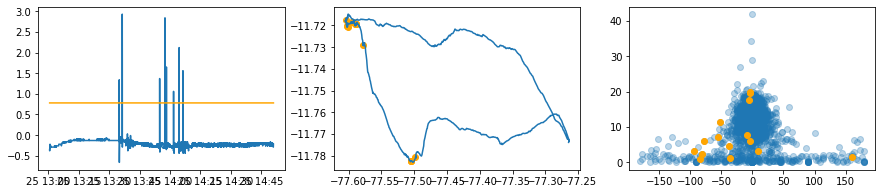

In [21]:
t.plot()

In [22]:
t.get_duration()

Timedelta('0 days 01:50:26')

In [23]:
t.get_distance()

88.1484595608965

In [24]:
t.df.head()

,trip,datetime,pressure,lon,lat,step,cap,direction,dive,cos_cap,sin_cap,step_std,direction_std,lon_std_mm,lat_std_mm
0,P1108_4_SV_T1,2008-11-25 13:00:35,-0.35,-77.264128,-11.773317,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.999801,0.143444
1,P1108_4_SV_T1,2008-11-25 13:00:36,-0.38,-77.264118,-11.773235,9.192428,6.808074,NaN,0,0.865380,0.501117,-1.114452,NaN,0.999830,0.144644
2,P1108_4_SV_T1,2008-11-25 13:00:37,-0.35,-77.264098,-11.773152,9.492498,13.273123,6.465048,0,0.760475,0.649367,-1.033105,0.316087,0.999889,0.145858
3,P1108_4_SV_T1,2008-11-25 13:00:38,-0.29,-77.264113,-11.773060,10.370362,350.931311,-22.341812,0,0.600183,-0.799863,-0.795125,-1.099954,0.999845,0.147204
4,P1108_4_SV_T1,2008-11-25 13:00:39,-0.29,-77.264142,-11.772955,12.107480,344.870108,-6.061203,0,0.761557,-0.648098,-0.324208,-0.299658,0.999760,0.148740


## Dive Prediction

In [25]:
%%time

trajs = []
radius = 500
n = 1
for k in df.trip.unique():
    df_trip = df[df.trip == k]
    
    t = trip.Trip(df_trip)
    # add variables
    t.add_dive(threshold)
    t.add_step()
    t.add_cap()
    t.add_direction()
    t.df['cos_cap'] = np.cos(t.df.cap)
    t.df['sin_cap'] = np.sin(t.df.cap)

    # standardized trajectories
    t.standardize(('step', 'direction'))
    t.standardize_minmax(('lon', 'lat'))

    trajs.append(t.df)
    
    IPython.display.clear_output(wait=True)
    print('Trip [{}/{}]'.format(n, len(df.trip.unique())))
    n+=1

Trip [170/170]
CPU times: user 19.9 s, sys: 321 ms, total: 20.2 s
Wall time: 20.1 s


In [26]:
trajs[0]

,trip,datetime,pressure,lon,lat,dive,step,cap,direction,cos_cap,sin_cap,step_std,direction_std,lon_std_mm,lat_std_mm
0,P1108_4_SV_T1,2008-11-25 13:00:35,-0.35,-77.264128,-11.773317,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999801,0.143444
1,P1108_4_SV_T1,2008-11-25 13:00:36,-0.38,-77.264118,-11.773235,0,9.192428,6.808074,NaN,0.865380,0.501117,-1.114452,NaN,0.999830,0.144644
2,P1108_4_SV_T1,2008-11-25 13:00:37,-0.35,-77.264098,-11.773152,0,9.492498,13.273123,6.465048,0.760475,0.649367,-1.033105,0.316087,0.999889,0.145858
3,P1108_4_SV_T1,2008-11-25 13:00:38,-0.29,-77.264113,-11.773060,0,10.370362,350.931311,-22.341812,0.600183,-0.799863,-0.795125,-1.099954,0.999845,0.147204
4,P1108_4_SV_T1,2008-11-25 13:00:39,-0.29,-77.264142,-11.772955,0,12.107480,344.870108,-6.061203,0.761557,-0.648098,-0.324208,-0.299658,0.999760,0.148740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6622,P1108_4_SV_T1,2008-11-25 14:50:57,-0.29,-77.264097,-11.773710,0,15.773785,194.809616,17.804082,0.999524,0.030867,0.669693,0.873473,0.999892,0.137695
6623,P1108_4_SV_T1,2008-11-25 14:50:58,-0.29,-77.264223,-11.773817,0,18.176315,229.059760,34.250144,-0.962016,0.272994,1.320996,1.681902,0.999523,0.136130
6624,P1108_4_SV_T1,2008-11-25 14:50:59,-0.26,-77.264307,-11.773860,0,10.329409,242.394637,13.334877,-0.881389,-0.472392,-0.806227,0.653783,0.999277,0.135500
6625,P1108_4_SV_T1,2008-11-25 14:51:00,-0.22,-77.264363,-11.773875,0,6.326643,254.697607,12.302970,-0.973984,-0.226616,-1.891339,0.603058,0.999113,0.135281


In [27]:
test_trajs_idx = np.random.randint(0, len(df.trip.unique()), 30)

test_trajs = [trajs[i] for i in test_trajs_idx]
train_trajs = [trajs[i] for i in range(len(df.trip.unique())) if i not in test_trajs_idx]

## Neural Networks

In [28]:
# pytorch materials
import torch
from torch import nn
from torch import optim
import torchvision as tv
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [29]:
class Sampler:
    def __init__(self, trajs, epoch, batch_size, input_var, output_var):
      # raw trajectories
      self.trajs = trajs
      self.n = len(trajs)
      # sample input specificities
      self.epoch = epoch
      self.batch_size = batch_size
      self.input_var = input_var
      self.output_var = output_var


    def sample(self):
      input_batch = []
      output_batch = []
      for i in range(self.batch_size):
        # look for a long trip
        dt = []
        while len(dt) < epoch:
            traj_idx = np.random.randint(self.n)
            dt = self.trajs[traj_idx]

        # select part of this trip
        epoch_idx = np.random.randint(2, len(dt)-epoch)

        input_trajs = dt.loc[epoch_idx:epoch_idx+epoch-1, self.input_var]
        output_trajs = dt.loc[epoch_idx:epoch_idx+epoch-1, self.output_var]

        # add it to batch
        input_batch.append(input_trajs.to_numpy().T)
        output_batch.append(output_trajs.to_numpy().T)

      # convert to tensor
      input_batch = torch.FloatTensor(input_batch)
      output_batch = torch.FloatTensor(output_batch)

      return (input_batch, output_batch)

In [30]:
# Hyperparameters
epoch = 100
batch_size = 8
learning_rate = 0.001
input_var = ('lon_std_mm', 'lat_std_mm', 'step_std', 'direction_std', 'cos_cap', 'sin_cap')
output_var = ('dive')

train = Sampler(train_trajs, epoch, batch_size, input_var, output_var)
test = Sampler(test_trajs, epoch, batch_size, input_var, output_var)

(x, y) = train.sample()

x.size()

torch.Size([8, 6, 100])

In [31]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.cnn_input_1 = nn.Sequential(
            nn.Conv1d(6, 8, kernel_size = 26, stride = 1, padding = 25, dilation = 2),
            nn.ReLU(),
            nn.Conv1d(8, 8, kernel_size = 26, stride = 1, padding = 25, dilation = 2),
            nn.ReLU()
        )

        self.pooling_1 = nn.Sequential(
            nn.MaxPool1d(kernel_size = 26, stride = 1, padding = 7, dilation = 2)
        )

        self.cnn_input_2 = nn.Sequential(
            nn.Conv1d(8, 16, kernel_size = 11, stride = 1, padding = 10, dilation = 2),
            nn.ReLU(),
            nn.Conv1d(16, 16, kernel_size = 11, stride = 1, padding = 10, dilation = 2),
            nn.ReLU()
        )

        self.pooling_2 = nn.Sequential(
            nn.MaxPool1d(kernel_size = 15, stride = 2, padding = 7, dilation = 1)
        )

        self.cnn_input_3 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size = 6, stride = 1, padding = 5, dilation = 2),
            nn.ReLU(),
            nn.Conv1d(32, 32, kernel_size = 6, stride = 1, padding = 5, dilation = 2),
            nn.ReLU()
        )

        self.pooling_3 = nn.Sequential(
            nn.MaxPool1d(kernel_size = 11, stride = 2, padding = 5, dilation = 1)
        )

        self.cnn_4 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size = 3, stride = 1, padding = 2, dilation = 2),
            nn.ReLU()
        )
        
        self.upconv_3 = nn.Sequential(
            nn.ConvTranspose1d(64, 32, kernel_size = 12, stride = 2, padding = 5, dilation = 1)
        )

        self.cnn_output_3 = nn.Sequential(
            nn.Conv1d(64, 32, kernel_size = 6, stride = 1, padding = 5, dilation = 2),
            nn.ReLU(),
            nn.Conv1d(32, 32, kernel_size = 6, stride = 1, padding = 5, dilation = 2),
            nn.ReLU()
        )

        self.upconv_2 = nn.Sequential(
            nn.ConvTranspose1d(32, 16, kernel_size = 22, stride = 2, padding = 10, dilation = 1)
        )

        self.cnn_output_2 = nn.Sequential(
            nn.Conv1d(32, 16, kernel_size = 11, stride = 1, padding = 10, dilation = 2),
            nn.ReLU(),
            nn.Conv1d(16, 16, kernel_size = 11, stride = 1, padding = 10, dilation = 2),
            nn.ReLU()
        )

        self.upconv_1 = nn.Sequential(
            nn.ConvTranspose1d(16, 8, kernel_size = 20, stride = 2, padding = 23, dilation = 1)
        )
         
        self.cnn_output_1 = nn.Sequential(
            nn.Conv1d(16, 2, kernel_size = 26, stride = 1, padding = 25, dilation = 2),
            nn.ReLU(),
            nn.Conv1d(2, 1, kernel_size = 26, stride = 1, padding = 25, dilation = 2),
            nn.Sigmoid()
        )
                
    def forward(self, x):
        out_1 = self.cnn_input_1(x)
        out = self.pooling_1(out_1)
        out_2 = self.cnn_input_2(out)
        out = self.pooling_2(out_2)
        out_3 = self.cnn_input_3(out)
        out = self.pooling_3(out_3)
        out = self.cnn_4(out)
        out = self.upconv_3(out)
        out = torch.cat((out, out_3), 1)
        out = self.cnn_output_3(out)
        out = self.upconv_2(out)
        out = torch.cat((out, out_2), 1)
        out = self.cnn_output_2(out)
        out = self.upconv_1(out)
        out = torch.cat((out, out_1), 1)
        out = self.cnn_output_1(out)

        return out.reshape((8, 100))

In [32]:
model = ConvNet()
out = model(x)
out.size()

torch.Size([8, 100])

In [33]:
# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [34]:
criterion(out, y)

tensor(0.7183, grad_fn=<BinaryCrossEntropyBackward>)

In [35]:
## estimate a relevant nb of total step
test_step = 1000

total_step = round(0.7 * (len(df) - len(df_trip.trip.unique()) * epoch)/batch_size)
total_step

75497

In [36]:
# switch to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
model.to(device)

In [41]:
# Train the model
list_score =[]
list_loss = []
for i in range(total_step):
    
    # Train the model
    model.train()
    (x,y) = train.sample() 
    x, y = x.to(device), y.to(device)

    # Run the forward pass
    out = model(x)
    loss = criterion(out, y)

    # Backprop and perform optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

    if (i + 1) % 1000 == 0:  
        # Test the model
        model.eval()
        with torch.no_grad():
            real = []
            estim = []
            for k in range(test_step):
                (x,y) = test.sample()
                x, y = x.to(device), y.to(device)
                out = model(x)
                
                # dive prediction
                real.append( y.cpu().reshape(800).detach().numpy() )
                estim.append( out.cpu().reshape(800).detach().numpy() )

            real = np.hstack(real)
            estim = np.hstack(estim)

            # no dive prediction performance
            no_dive_prediction = [estim[i] for i in range(estim.shape[0]) if not real[i]]
            true_no_dive = 1-np.sum(no_dive_prediction)/len(no_dive_prediction)

            # dive prediction performance
            dive_prediction = [estim[i] for i in range(estim.shape[0]) if real[i]]
            true_dive = np.sum(dive_prediction)/len(dive_prediction)
        
            score = (true_no_dive + true_dive)/2

            list_loss.append(loss.item())
            list_score.append(score)


        print('Step [{}/{}], Loss: {:.4f}, Accuracy: {} %'
              .format(i + 1, total_step, loss.item(), score*100))

Step [1000/75497], Loss: 0.0828, Accuracy: 50.46218484269197 %
Step [2000/75497], Loss: 0.0419, Accuracy: 50.39848958013806 %
Step [3000/75497], Loss: 0.0536, Accuracy: 50.465891507764624 %
Step [4000/75497], Loss: 0.0685, Accuracy: 50.4791366775675 %
Step [5000/75497], Loss: 0.0853, Accuracy: 50.46586422541931 %


KeyboardInterrupt: ignored

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         

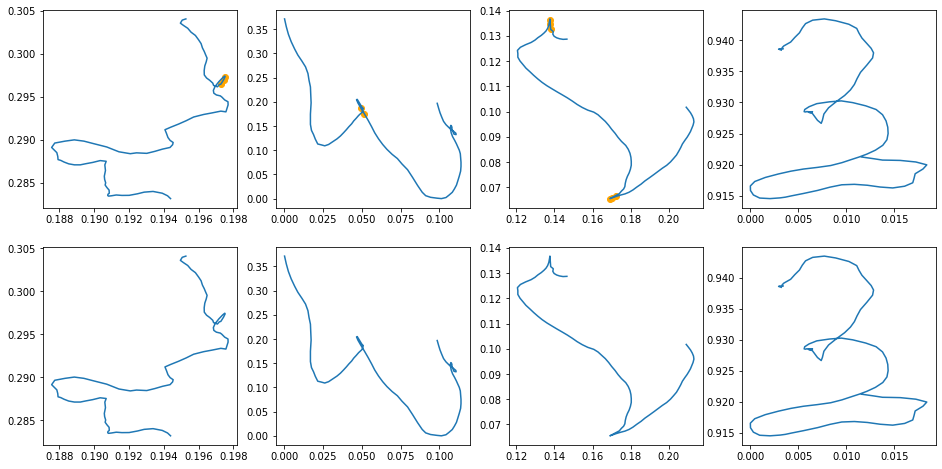

In [43]:
plt.figure(figsize=(16, 8))

for i in range(4):
# i = 0
    lon = x.cpu().numpy()[i][0]
    lat = x.cpu().numpy()[i][1]

    real = y.cpu().numpy()[i]
    estim = out.cpu().detach().numpy()[i] > 0.5

    plt.subplot(2, 4, i+1)
    plt.plot(lon, lat)
    plt.scatter(lon[np.where(real)], lat[np.where(real)], c='orange')
    
    plt.subplot(2, 4, i+5)
    plt.plot(lon, lat)
    plt.scatter(lon[np.where(estim)], lat[np.where(estim)], c='red')


In [45]:
out.cpu().detach().numpy()[0]

array([0.13880457, 0.10749094, 0.12828489, 0.10019046, 0.1219615 ,
       0.08575555, 0.10651306, 0.07000557, 0.08820454, 0.06963298,
       0.0872632 , 0.06549179, 0.0840134 , 0.06451691, 0.08260219,
       0.06105035, 0.07686725, 0.05239073, 0.0666916 , 0.04091734,
       0.0545047 , 0.03202413, 0.04396993, 0.02409761, 0.03421549,
       0.02005609, 0.02829347, 0.01858752, 0.02593635, 0.01724405,
       0.02471411, 0.01566415, 0.02274739, 0.01496995, 0.0215122 ,
       0.01379089, 0.02022187, 0.01279286, 0.01843291, 0.01207624,
       0.0176992 , 0.01114384, 0.01674309, 0.01051822, 0.01556304,
       0.010087  , 0.01519651, 0.0099276 , 0.0147888 , 0.00993222,
       0.01455204, 0.01018314, 0.01443364, 0.0102519 , 0.01476571,
       0.01036165, 0.01514071, 0.01096861, 0.01603888, 0.01137095,
       0.01637531, 0.01185809, 0.01644869, 0.01282714, 0.01761239,
       0.01342467, 0.01822671, 0.01432218, 0.01947693, 0.01544009,
       0.02032144, 0.01681101, 0.02175326, 0.01784179, 0.02382